In [32]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style('dark')

import json
import os
import datetime

from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import cairosvg
from PIL import Image
import albumentations as A
import cv2
import tensorflow as tf

In [33]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Динамічне виділення пам'яті
    except RuntimeError as e:
        print(e)

In [34]:
with open("../configs/config.json", "r") as file:
    config = json.load(file)

# Виведення конфігурації
print(config)

{'data': {'raw_path': '../data/raw/svg', 'png_path': '../data/precessed/png_images', 'precessed_train_path': '../data/tfrec/train/', 'precessed_valid_path': '../data/tfrec/val/', 'class_names': ['airplane', 'alarm clock', 'angel', 'ant', 'apple', 'arm', 'armchair', 'ashtray', 'axe', 'backpack', 'banana', 'barn', 'baseball bat', 'basket', 'bathtub', 'bear (animal)', 'bed', 'bee', 'beer-mug', 'bell', 'bench', 'bicycle', 'binoculars', 'blimp', 'book', 'bookshelf', 'boomerang', 'bottle opener', 'bowl', 'brain', 'bread', 'bridge', 'bulldozer', 'bus', 'bush', 'butterfly', 'cabinet', 'cactus', 'cake', 'calculator', 'camel', 'camera', 'candle', 'cannon', 'canoe', 'car (sedan)', 'carrot', 'castle', 'cat', 'cell phone', 'chair', 'chandelier', 'church', 'cigarette', 'cloud', 'comb', 'computer monitor', 'computer-mouse', 'couch', 'cow', 'crab', 'crane (machine)', 'crocodile', 'crown', 'cup', 'diamond', 'dog', 'dolphin', 'donut', 'door', 'door handle', 'dragon', 'duck', 'ear', 'elephant', 'envelope

In [35]:
# Constants
IMAGE_SIZE = (config['model']['input_size'], config['model']['input_size'])
img_size = config['model']['input_size']
BATCH_SIZE = config['model']['batch_size']
NUM_CLASSES = config['model']['output_size']
PNG_DIR = config['data']['png_path']
TFREC_TRAIN_DIR = config['data']['precessed_train_path']
TFREC_VALID_DIR = config['data']['precessed_valid_path']
MODEL_FINAL_DIR = config['training']['final_model_dir']
MODEL_CHECK_DIR = config['training']['checkpoint_dir']
class_names = sorted(os.listdir(PNG_DIR))

In [36]:
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance


# Функція для парсингу TFRecord
def parse_tfrecord_onehot(example_proto, num_classes):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([num_classes], tf.float32),
    }
    example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.image.decode_jpeg(example['image'], channels=3)  # Декодуємо JPEG
    image = tf.image.convert_image_dtype(image, tf.float32)  # Конвертуємо в float32
    label = example['label']
    return image, label

# Завантажуємо TFRecord файли
def load_tfrecord_onehot_dataset(tfrecord_files, num_classes, batch_size=BATCH_SIZE):
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(lambda x: parse_tfrecord_onehot(x, num_classes), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def augment_image(image):
    # Випадкове горизонтальне віддзеркалення
    image = tf.image.random_flip_left_right(image)

    return image

# Функція для застосування аугментації під час завантаження даних
def augment_image_during_training(image, label):
    image = augment_image(image)
    return image, label


# Завантажуємо тренувальний датасет
train_tfrecord_files = [os.path.join(TFREC_TRAIN_DIR, f) for f in os.listdir(TFREC_TRAIN_DIR) if f.endswith('.tfrecord')]
train_dataset = load_tfrecord_onehot_dataset(train_tfrecord_files, NUM_CLASSES, batch_size=BATCH_SIZE)

# Застосовуємо аугментацію до тренувального датасету
train_dataset = train_dataset.map(
    augment_image_during_training,
    num_parallel_calls=tf.data.AUTOTUNE
)

# Додаємо батчування та prefetch для оптимізації
train_dataset = train_dataset.repeat().prefetch(tf.data.AUTOTUNE)

# Розраховуємо загальну кількість тренувальних зразків
total_train_samples = sum(1 for _ in tf.data.TFRecordDataset(train_tfrecord_files))


# Завантажуємо валідаційний датасет
val_tfrecord_files = [os.path.join(TFREC_VALID_DIR, f) for f in os.listdir(TFREC_VALID_DIR) if f.endswith('.tfrecord')]
val_dataset = load_tfrecord_onehot_dataset(val_tfrecord_files, NUM_CLASSES, batch_size=BATCH_SIZE)

# Додаємо батчування та prefetch для валідаційного датасету
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Розраховуємо загальну кількість валідаційних зразків
total_val_samples = sum(1 for _ in tf.data.TFRecordDataset(val_tfrecord_files))

steps_per_epoch = (total_train_samples + BATCH_SIZE - 1) // BATCH_SIZE
validation_steps = (total_val_samples + BATCH_SIZE - 1) // BATCH_SIZE




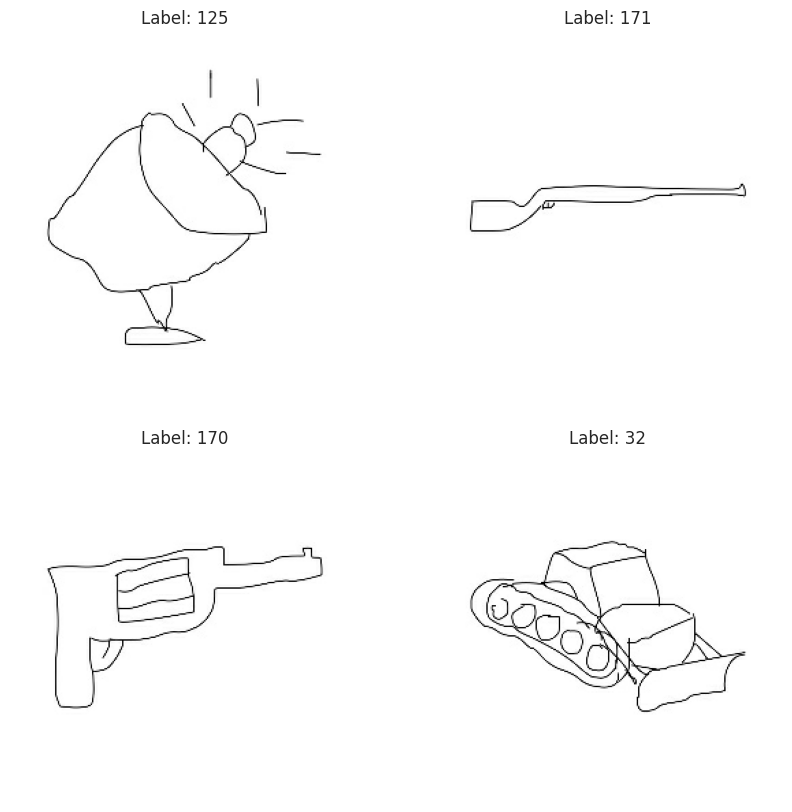

In [37]:
def visualize_images(dataset, num_images=4, is_onehot=False):
    # Беремо один батч з даними
    for images, labels in dataset.take(1):
        images = images.numpy()  # Конвертуємо тензори в NumPy
        labels = labels.numpy()

        # Перевіряємо, чи є дані в батчі
        batch_size = images.shape[0]
        if batch_size == 0:
            raise ValueError("Батч порожній, перевірте ваш датасет.")
        
        # Візуалізуємо тільки до num_images зображень
        num_images = min(num_images, batch_size)

        # Створюємо сітку для візуалізації
        plt.figure(figsize=(10, 10))
        for i in range(num_images):
            plt.subplot(2, 2, i + 1)
            
            # Отримуємо одне зображення
            image = images[i]

            # Відображення залежно від діапазону значень
            if image.max() > 1.0:
                plt.imshow(image.astype('uint8'))
            else:
                plt.imshow(image)
            
            # Отримуємо мітку
            if is_onehot:
                label = np.argmax(labels[i])
            else:
                label = labels[i]
            
            plt.title(f"Label: {label}")
            plt.axis('off')
        plt.show()

# Виклик функції з урахуванням батчів
visualize_images(train_dataset, is_onehot=True)


In [ ]:
from tensorflow.keras.applications import MobileNetV2, VGG19, EfficientNetB0 
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# Функція для створення моделі

model_name = "EfficientNetB0"
EPOCHS = 10
LAYERS_TO_UNFREEZE1 = 6 # Кількість шарів, які не тренуватимуться
LAYERS_TO_UNFREEZE2 = 12  # Кількість шарів, які не тренуватимуться


base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)  # 1024 for MobileNetV2, for VGG19 needed like 4096
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)  # num_classes should match your dataset

model = Model(inputs=base_model.input, outputs=predictions)

2025-01-19 17:45:57.919277: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737308758.011966     920 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737308758.039275     920 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-19 17:45:58.257461: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ImportError: cannot import name 'EfficientNet' from 'tensorflow.keras.applications' (/home/qizixxx/mlbook/.venv/lib/python3.12/site-packages/keras/_tf_keras/keras/applications/__init__.py)

In [28]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint(MODEL_CHECK_DIR + model_name + 'base.keras', monitor='val_accuracy', save_best_only=True)
]

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history_stage_1 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch, 
    validation_steps=validation_steps 
)

Epoch 1/10


2025-01-19 14:28:53.228399: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1430', 36 bytes spill stores, 36 bytes spill loads

2025-01-19 14:28:55.117664: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng33{k2=2,k6=2,k13=1,k14=0,k22=0} for conv (f32[16,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,256,256]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-01-19 14:28:55.736815: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.619382007s
Trying algorith

 998/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.0822 - loss: 4.8493

2025-01-19 14:29:54.892903: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1430', 44 bytes spill stores, 44 bytes spill loads



1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 72ms/step - accuracy: 0.0824 - loss: 4.8474 - val_accuracy: 0.3575 - val_loss: 2.9976 - learning_rate: 1.0000e-04
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 66s 66ms/step - accuracy: 0.3490 - loss: 2.9730 - val_accuracy: 0.4793 - val_loss: 2.3355 - learning_rate: 1.0000e-04
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 68s 68ms/step - accuracy: 0.4692 - loss: 2.3596 - val_accuracy: 0.5318 - val_loss: 2.0329 - learning_rate: 1.0000e-04
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 82ms/step - accuracy: 0.5321 - loss: 2.0128 - val_accuracy: 0.5595 - val_loss: 1.8573 - learning_rate: 1.0000e-04
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 68s 68ms/step - accuracy: 0.5793 - loss: 1.7994 - val_accuracy: 0.5723 - val_loss: 1.7651 - learning_rate: 1.0000e-04
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 70s 70ms/step - accuracy: 0.6082 - loss: 1.6261 - val_accuracy: 0.5872 - val_loss: 1.6910 - learning_rate: 1.0000e-04
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 68s 68ms/

In [29]:
for layer in model.layers[-LAYERS_TO_UNFREEZE1:]: 
    layer.trainable = True

# Recompile the model to apply the changes
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training with a very low learning rate
history_stage_2 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 74s 71ms/step - accuracy: 0.7045 - loss: 1.1782 - val_accuracy: 0.6355 - val_loss: 1.4569 - learning_rate: 1.0000e-05
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 69s 69ms/step - accuracy: 0.7184 - loss: 1.1376 - val_accuracy: 0.6380 - val_loss: 1.4497 - learning_rate: 1.0000e-05
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 69s 69ms/step - accuracy: 0.7201 - loss: 1.1226 - val_accuracy: 0.6428 - val_loss: 1.4448 - learning_rate: 1.0000e-05
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 69s 69ms/step - accuracy: 0.7268 - loss: 1.1070 - val_accuracy: 0.6413 - val_loss: 1.4407 - learning_rate: 1.0000e-05
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 69s 69ms/step - accuracy: 0.7293 - loss: 1.0988 - val_accuracy: 0.6445 - val_loss: 1.4380 - learning_rate: 1.0000e-05
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 69s 69ms/step - accuracy: 0.7346 - loss: 1.0871 - val_accuracy: 0.6430 - val_loss: 1.4334 - learning_rate: 1.0000e-05
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7),
    ModelCheckpoint(MODEL_CHECK_DIR + model_name + 'fine.keras', monitor='val_accuracy', save_best_only=True)
]

for layer in model.layers[-LAYERS_TO_UNFREEZE2:]:  # Unfreeze last 6 layers
    layer.trainable = True

# Recompile the model to apply the changes
model.compile(optimizer=Adam(learning_rate=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training with a very low learning rate
history_stage_3 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,  # Кількість кроків на епоху
    validation_steps=validation_steps
)

Epoch 1/10


 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7349 - loss: 1.0108

2025-01-19 14:54:18.279361: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1692', 344 bytes spill stores, 344 bytes spill loads



1000/1000 ━━━━━━━━━━━━━━━━━━━━ 111s 104ms/step - accuracy: 0.7350 - loss: 1.0107 - val_accuracy: 0.6560 - val_loss: 1.3834 - learning_rate: 1.0000e-05
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 98s 98ms/step - accuracy: 0.7886 - loss: 0.7854 - val_accuracy: 0.6785 - val_loss: 1.2909 - learning_rate: 1.0000e-05
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 98s 98ms/step - accuracy: 0.8153 - loss: 0.6840 - val_accuracy: 0.6855 - val_loss: 1.2498 - learning_rate: 1.0000e-05
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 98s 98ms/step - accuracy: 0.8473 - loss: 0.5695 - val_accuracy: 0.6908 - val_loss: 1.2580 - learning_rate: 1.0000e-05
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 98s 98ms/step - accuracy: 0.8733 - loss: 0.4794 - val_accuracy: 0.7028 - val_loss: 1.2029 - learning_rate: 1.0000e-05
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 98s 98ms/step - accuracy: 0.8945 - loss: 0.4069 - val_accuracy: 0.6998 - val_loss: 1.2262 - learning_rate: 1.0000e-05
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 99s 99m

In [ ]:
for layer in model.layers:
    layer.trainable = True

# Recompile the model to apply the changes
model.compile(optimizer=Adam(learning_rate=1e-7), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training with a very low learning rate
history_stage_3 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch, 
    validation_steps=validation_steps
)

In [ ]:
model.save(MODEL_FINAL_DIR + model_name + '.keras')